# Understat Series : xG Flow Chart



**By Jose Gonzalez**

**Was greatly inspired by the [McKay Johns tutorial](https://www.youtube.com/watch?v=bvoOOYMQkac) he has great tutorials on shotmaps, passing networks, dashboards etc , [here is his Youtube channel](https://www.youtube.com/c/mckayjohns)**

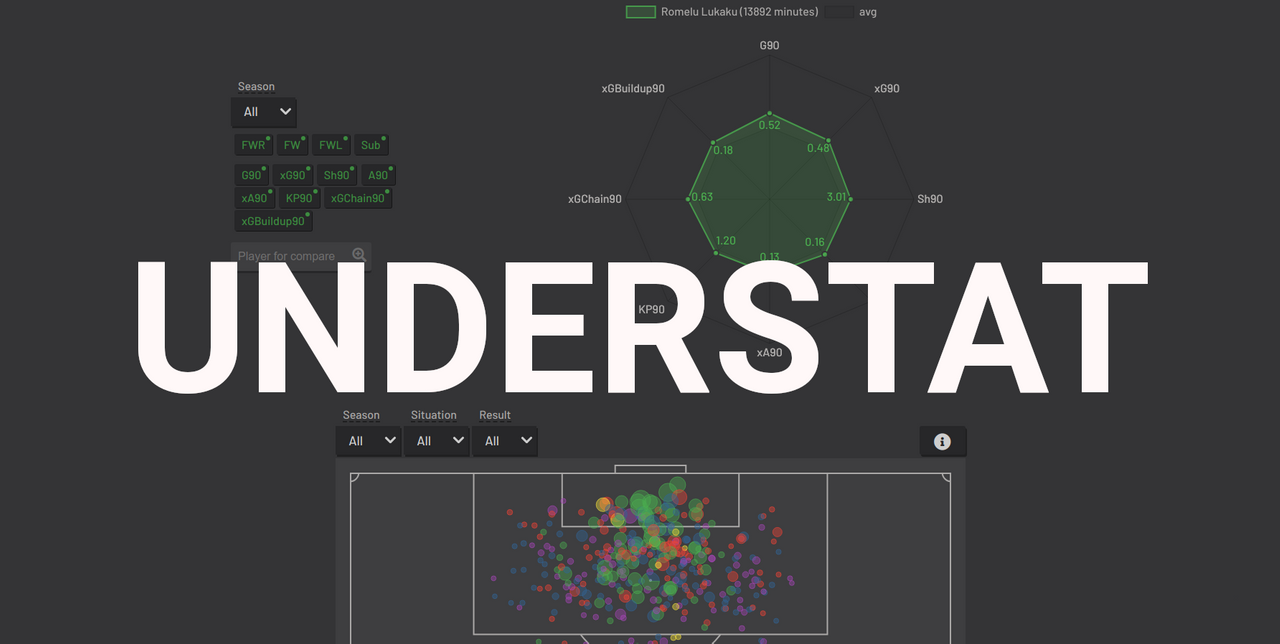

<a id="1."></a>
# Introduction
Let's explore Expected goals flowcharts, heavily inspired by the tutorials from [McKay Johns Youtube channel](https://www.youtube.com/c/mckayjohns) We'll scrape the match data and then plot it to obtain a xG flowchart to try t to illustrate better the match on expected goals and goals scored.

<a id="1.1"></a>
## Notebook content
* [1. Introduction](#1.)
    - [1.1. Notebook Content.](#1.1)
* [2.Importing libraries.](#2.)
* [3.Scraping Match Data.](#3.)
* [4. Cleaning Data](#4.)
    - [4.1. Renaming columns and changing data.](#4.1)
    - [4.2. Rounding numbers and creating lists](#4.2)
* [5. Plotting xG Flow Chart](#5.)
* [6. References](#6.)

<a id="2."></a>
# Importing Libraries

In [11]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.patches import Arc
import numpy as np
from highlight_text import fig_text
import seaborn as sns
import requests
from bs4 import BeautifulSoup

<a id="3."></a>
# Scraping Match Data
Let' first proceed to scrape the data from Understat using requests and BS4 : 

In [12]:
# Entering Real Sociedad vs Barcelona match link
link = "https://understat.com/match/15054"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')

# Get the shotsData, it's the second script executed in order
strings = scripts[1].string 

# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
shots_match = json.loads(json_data)

<a id="4."></a>
# Cleaning data 
Once we've scraped the data let's proceed to clean the data by renaming columns and by changing data types from objects to float types to be able to fully manipulate the data

<a id="4.1"></a>
## Renaming columns and changing data types

In [13]:
# Creatinf the 2 dfs

df_away = pd.DataFrame(shots_match['a'])
df_home = pd.DataFrame(shots_match['h'])

# Selecting only the useful columns

df_away = df_away[['minute','player',"a_team",'result','xG','h_a']]
df_home = df_home[['minute','player',"h_team",'result','xG','h_a']]

# Renaming columns 

df_away.rename(columns={"a_team": "team"})
df_home.rename(columns={"h_team": "team"})

# Changing data types

df_away = df_away.astype({"xG": float, "minute": float})
df_home = df_home.astype({"xG": float, "minute": float})

# Creating new column xG cumulative
df_away['xGcum'] = np.cumsum(df_away['xG'])
df_home['xGcum'] = np.cumsum(df_home['xG'])

<a id="4.2"></a>
## Rounding numbers and creating lists
Let's now continue by rounding the results up to just 2 decimals and creating the lists , instead of calling big series values such as  "df_home[df_home['result']=='Goal']['minute']" .values" for example.

In [19]:
# creating the dictionaries
x = df_home[df_home['result']=='Goal']['minute'].tolist()
x1 = df_away[df_away['result']=='Goal']['minute'].tolist()
y =df_home[df_home['result']=='Goal']['xGcum'].tolist()
y1 = df_away[df_away['result']=='Goal']['xGcum'].tolist()

# xG inside the scatterplots
y_plot =np.round(df_home[df_home['result']=='Goal']['xG'],2).tolist()
y1_plot = np.round(df_away[df_away['result']=='Goal']['xG'],2).tolist()

# Annotation text
text_home = df_home[df_home['result']=='Goal']['player'].tolist()
text_away = df_away[df_away['result']=='Goal']['player'].tolist()
label_home = df_home['h_team'].unique().tolist()
label_away = df_away['a_team'].unique().tolist()

# More annotation text
xGcum_away = str(np.round(df_away['xGcum'].iloc[-1],3))
xGcum_home = str(np.round(df_home['xGcum'].iloc[-1],3))
team_away = str(df_away['a_team'].iloc[-1])
team_home = str(df_home['h_team'].iloc[-1])

<a id="5."></a>
# Plotting xG flow
Let's finally plot the xG accumulated, at the center we'll be annotating the quality of the chance of every goal scored: 

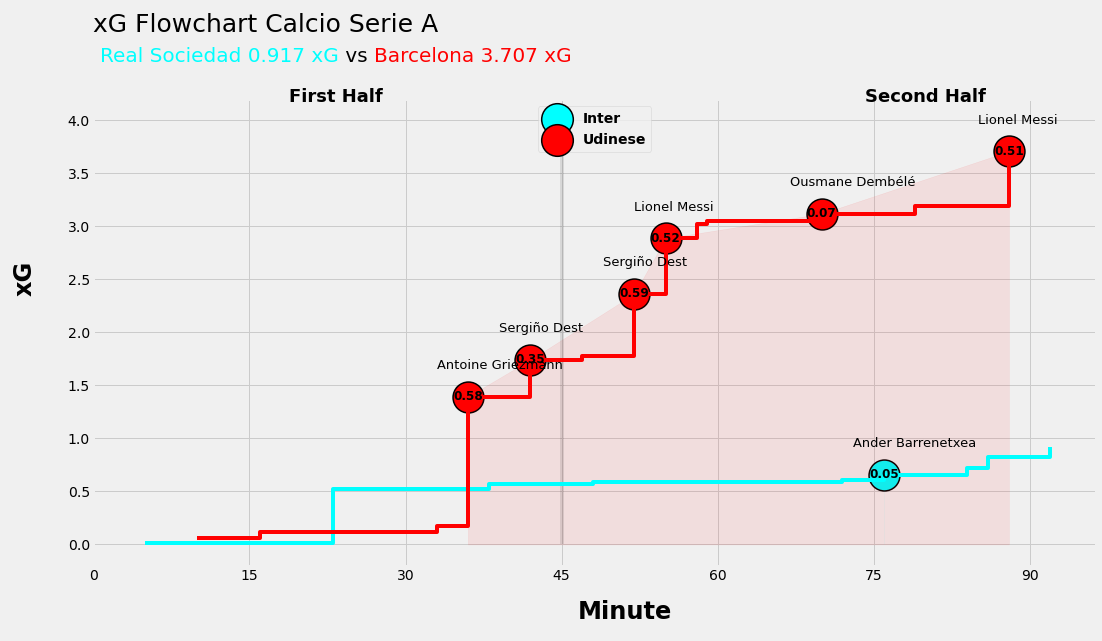

In [21]:
# plot style 
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize = (16,8))

# Step plot for Inter and Udinese 
ax.step(x = df_home['minute'] ,y = df_home['xGcum'] , where = 'post', color = 'cyan' ,linewidth = 4.0)
ax.step(x = df_away['minute'] ,y = df_away['xGcum'] , where = 'post', color = 'red' ,linewidth = 4.0)

#sns.scatterplot(x=x,y=y,s=430,marker='o',color='yellow')
ax.scatter(x=x,y=y, color='cyan', edgecolor='black',s=955, label="Inter",linewidths=1.5,)
ax.scatter(x=x1,y=y1, color='red', edgecolor='black',s=955, label="Udinese",linewidths=1.5)

#FILL AREA BETWEEN LINE AND X 
plt.fill_between(x,y, alpha=0.08, color='cyan')
plt.fill_between(x1,y1, alpha=0.08, color='red')

# Text annotation for goals
for i in range(len(x1)):
    plt.annotate(text_away[i], (x1[i]- 3, y1[i] + 0.26),c='black',size=13)
for i in range(len(x)):
    plt.annotate(text_home[i], (x[i]- 3, y[i] + 0.26),c='black',size=13)

# legend
legend = ax.legend(loc="upper center",prop={'weight':'bold'})
legend.legendHandles[0]._sizes = [1000]
legend.legendHandles[1]._sizes = [1000]

# title
fig_text(0.08,1.03, s="xG Flowchart Calcio Serie A\n", fontsize = 25, fontweight = "light")
fig_text(0.08,0.97, s=" <{} {} xG> vs <{} {} xG>".format(team_home,xGcum_home,team_away,xGcum_away),highlight_textprops=[{"color":'cyan'}, {'color':"red"}], fontsize = 20, fontweight="light")

# text
fig_text(0.5,0.01, s="Minute\n", fontsize = 24, fontweight = "bold", color = "black")
fig_text(0.01,0.6, s="xG\n", fontsize = 24, fontweight = "bold", color = "black",rotation=90)
fig_text(0.25,0.9, s="First Half\n", fontsize = 18, fontweight = "bold", color = "black")
fig_text(0.75,0.9, s="Second Half\n", fontsize = 18, fontweight = "bold", color = "black")

# Finally a dotted line to separate the HT 
plt.vlines( ymin=0, ymax=4,x=45, color='black', alpha=0.1,linestyle="solid")
# ticks
plt.xticks([0,15,30,45,60,75,90])
plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4])

# Annotate quality chances inside the scatterplots

# Home team
for i in range(len(x)):
    plt.annotate(y_plot[i], (x[i], y[i]),c='black',size=12,ha='center',va='center',fontweight='bold')
# Away team
for i in range(len(x1)):
    plt.annotate(y1_plot[i], (x1[i], y1[i]),c='black',size=12,ha='center',va='center',fontweight='bold')

This game was a complete domination by FC Barcelona scoring 6 goals and having by far much more xG accumulated

<a id="6."></a>
# References
The main reference for this notebook were : 

   1. [McKay Johns tutorial](https://www.youtube.com/watch?v=bvoOOYMQkac)
   2. [And this other from this guy](https://github.com/patryklowicki/football_analysis/blob/master/team_stats/team_xg_per_game_c.ipynb)